In [5]:
import sys
print(sys.executable)

c:\Users\liuxt\AppData\Local\miniconda3\envs\M3X_WS\python.exe


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, TensorBoard
import matplotlib.pyplot as plt
import scipy.io
import random
import os

seed = 42 

# Set Python random seed
random.seed(seed)
# Set NumPy random seed
np.random.seed(seed)
# Set TensorFlow random seed
tf.random.set_seed(seed)
# (Optional) Set PYTHONHASHSEED environment variable for reproducibility in hashing
os.environ['PYTHONHASHSEED'] = str(seed)

# Set the mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)

In [7]:
# Load the .mat file
mat_file_path = r'C:\Users\liuxt\University of Michigan Dropbox\ENGIN-M3X\NSF M3X Balance Rating and Progression\Fall 2022 Data collection\M3X Weight Shifting Data\M3X WS Data 051525\M3X_training_trials_All_sensors_aw.mat'
M3X_data = scipy.io.loadmat(mat_file_path)

PH_mat_file_path = r"C:\Users\liuxt\University of Michigan Dropbox\ENGIN-PH\PH F'20 Data Collection\PH Weight Shifting Data\PH_training_trials_All_sensors_aw.mat"
PH_data = scipy.io.loadmat(PH_mat_file_path)
# Print the keys to see what variables are in the file
print(M3X_data.keys())
print(PH_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'training_data', 'training_labels', 'validation_data', 'validation_labels'])
dict_keys(['__header__', '__version__', '__globals__', 'training_data', 'training_labels', 'validation_data', 'validation_labels'])


In [8]:
# Access the data and labels
all_trial_matrices = M3X_data['training_data']
trial_labels = M3X_data['training_labels']

ph_trial_matrices = PH_data['training_data']
ph_trial_labels = PH_data['training_labels']

# Access the validation sets
M3X_val_matrices = M3X_data['validation_data']
M3X_val_labels = M3X_data['validation_labels']
PH_val_matrices = PH_data['validation_data']
PH_val_labels = PH_data['validation_labels']

# Print shapes for confirmation
print("M3X data shape:", all_trial_matrices.shape)
print("PH data shape:", ph_trial_matrices.shape)
print("M3X labels shape:", trial_labels.shape)
print("PH labels shape:", ph_trial_labels.shape)
print("M3X validation data shape:", M3X_val_matrices.shape)
print("M3X validation labels shape:", M3X_val_labels.shape)
print("PH validation data shape:", PH_val_matrices.shape)
print("PH validation labels shape:", PH_val_labels.shape)

# Concatenate along the first axis (subjects)
training_data_combined = np.concatenate((all_trial_matrices, ph_trial_matrices), axis=0)
training_labels_combined = np.concatenate((trial_labels, ph_trial_labels), axis=0)

# Combine validation sets
val_matrices_combined = np.concatenate((M3X_val_matrices, PH_val_matrices), axis=1)
val_labels_combined = np.concatenate((M3X_val_labels, PH_val_labels), axis=1)

print("Combined data shape:", training_data_combined.shape)
print("Combined labels shape:", training_labels_combined.shape)
print("Combined validation data shape:", val_matrices_combined.shape)
print("Combined validation labels shape:", val_labels_combined.shape)

M3X data shape: (17, 4, 3)
PH data shape: (46, 4, 3)
M3X labels shape: (17, 4, 3)
PH labels shape: (46, 4, 3)
M3X validation data shape: (1, 36)
M3X validation labels shape: (1, 36)
PH validation data shape: (1, 90)
PH validation labels shape: (1, 90)
Combined data shape: (63, 4, 3)
Combined labels shape: (63, 4, 3)
Combined validation data shape: (1, 126)
Combined validation labels shape: (1, 126)


In [34]:
# add a new feature (the timestamp of the first stepout) to the last linear layer 

# import the step-outs for training and validation sets
M3X_training_stepouts_file_path = r'C:\Users\liuxt\University of Michigan Dropbox\ENGIN-M3X\NSF M3X Balance Rating and Progression\Fall 2022 Data collection\M3X Weight Shifting Data\M3X WS Data 051525\M3X_training_stepouts.mat'
M3X_training_stepouts = scipy.io.loadmat(M3X_training_stepouts_file_path)['training_stepout']
PH_training_stepouts_file_path = r"C:\Users\liuxt\University of Michigan Dropbox\ENGIN-PH\PH F'20 Data Collection\PH Weight Shifting Data\PH_training_stepouts.mat"
PH_training_stepouts = scipy.io.loadmat(PH_training_stepouts_file_path)['training_stepout']
# Combine stepouts
training_stepouts_combined = np.concatenate((M3X_training_stepouts, PH_training_stepouts), axis=1)
# Combine validation stepouts
M3X_val_stepouts_file_path = r'C:\Users\liuxt\University of Michigan Dropbox\ENGIN-M3X\NSF M3X Balance Rating and Progression\Fall 2022 Data collection\M3X Weight Shifting Data\M3X WS Data 051525\M3X_validation_stepouts.mat'
M3X_val_stepouts = scipy.io.loadmat(M3X_val_stepouts_file_path)['validation_stepout']
PH_val_stepouts_file_path = r"C:\Users\liuxt\University of Michigan Dropbox\ENGIN-PH\PH F'20 Data Collection\PH Weight Shifting Data\PH_validation_stepouts.mat"
PH_val_stepouts = scipy.io.loadmat(PH_val_stepouts_file_path)['validation_stepout']
# Combine validation stepouts
val_stepouts_combined = np.concatenate((M3X_val_stepouts, PH_val_stepouts), axis=1)

# Print shapes for confirmation
print("Combined training stepouts shape:", training_stepouts_combined.shape)
print("Combined validation stepouts shape:", val_stepouts_combined.shape)

# convert the stepouts to an array
training_stepouts_combined = np.array(training_stepouts_combined)
val_stepouts_combined = np.array(val_stepouts_combined)


Combined training stepouts shape: (1, 398)
Combined validation stepouts shape: (1, 126)


In [ ]:
# parameters init & X_tensor / y_tensor processing

features = training_data_combined[0][0][0].shape[1]  # Number of features in each trial matrix
units = 8  # LSTM units
dropout_rate = 0.5  # Dropout rate
num_classes = 5  # Number of classes for classification 1 - 5 rating
# Initialize lists to hold the extracted data
X_list = []
y_list = []

# Loop through each cell in all_trial_matrices
for subject in training_data_combined:
    for exercise in subject:
        for trial in exercise:
            if trial.size > 0:  # Check if the session is not empty
                # Convert session to a numpy array and ensure it has the correct shape
                trial_array = np.array(trial)
                # Check if the session has enough dimensions
                if trial_array.ndim == 1:
                    trial_array = trial_array.reshape(-1, features)
                # if trial_array.shape[0] > 30000: #check if the session is too long
                #     continue
                X_list.append(trial_array)



# Compute mean and std for each feature across all data, ignoring NaNs
all_data = np.concatenate(X_list, axis=0)
feature_means = np.nanmean(all_data, axis=0)
feature_stds = np.nanstd(all_data, axis=0)
feature_stds[feature_stds == 0] = 1  # Prevent division by zero

X_list_norm = []
for x in X_list:
    x_norm = x.copy()
    # Normalize each feature independently, ignoring NaNs
    for f in range(x.shape[1]):
        mask = ~np.isnan(x[:, f])
        x_norm[mask, f] = (x[mask, f] - feature_means[f]) / feature_stds[f]
    # After normalization, set any remaining NaNs (missing sensors) to 0
    x_norm[np.isnan(x_norm)] = 0
    X_list_norm.append(x_norm)

# Pad sequences to the same length
# max_sequence_length = max(seq.shape[0] for seq in X_list_norm)
max_sequence_length = 17000
X_padded = pad_sequences(X_list_norm, maxlen=max_sequence_length, padding='post', dtype='float32', value=0)




In [10]:
# Normalize the validation data using training set statistics
X_val_list = []
for trial in val_matrices_combined[0]:
            if trial.size > 0:
                trial_array = np.array(trial)
                if trial_array.ndim == 1:
                    trial_array = trial_array.reshape(-1, features)
                trial_norm = trial_array.copy()
                for f in range(trial_array.shape[1]):
                    mask = ~np.isnan(trial_array[:, f])
                    trial_norm[mask, f] = (trial_array[mask, f] - feature_means[f]) / feature_stds[f]
                trial_norm[np.isnan(trial_norm)] = 0
                X_val_list.append(trial_norm)

X_val_padded = pad_sequences(X_val_list, maxlen=max_sequence_length, padding='post', dtype='float32', value=0)

In [33]:
# Label fusion for PH data
y_list = []
counter = 0
for subject in training_labels_combined:
    counter += 1
    if counter == 18:
         print("M3X labels: ", len(y_list))
    for exercise in subject:
        for trial in exercise:
            if trial.size > 0:  # Check if the session is not empty
                # Convert to float array, ignore NaNs in averaging
                trial_arr = np.array(trial, dtype=float)
                avg_label = np.nanmean(trial_arr)
                rounded_label = int(np.rint(avg_label))
                y_list.append(rounded_label)

# Label fusion for validation set
y_val_list = []
for trial in val_labels_combined[0]:
            if trial.size > 0:  # Check if the session is not empty
                trial_arr = np.array(trial, dtype=float)
                avg_label = np.nanmean(trial_arr)
                rounded_label = int(np.rint(avg_label))
                y_val_list.append(rounded_label)

print("Number of training samples:", len(X_padded))
print("Number of validation samples:", len(X_val_padded))
print("y_list:", len(y_list))
print("y_val_list:", len(y_val_list))



M3X labels:  57
Number of training samples: 398
Number of validation samples: 126
y_list: 398
y_val_list: 126


In [45]:
# convert validation set and labels into tensors
X_val_tensor = tf.convert_to_tensor(X_val_padded, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val_list, dtype=tf.int32)
stepout_val_tensor = tf.convert_to_tensor(val_stepouts_combined, dtype=tf.float32)

In [ ]:
# Check the shapes of the tensors
# print("x_tensor shape:",X_tensor.shape)
# print("tensor0 shape: ", X_tensor[0].shape)
# print("y_tensor shape:", y_tensor.shape)

# Check class distribution
unique, counts = np.unique(y_list, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

Class distribution:
Class 1: 133 samples
Class 2: 190 samples
Class 3: 40 samples
Class 4: 25 samples
Class 5: 10 samples


In [43]:
# Oversample minority classes to deal with class imbalance

from collections import Counter
from sklearn.utils import resample

# Convert X_list_norm and y_list to numpy arrays for easier indexing
X_array = X_padded
y_array = np.array(y_list)

# Count samples per class
class_counts = Counter(y_array)
max_count = max(class_counts.values())

X_resampled = []
y_resampled = []
stepouts_resampled = []

# Oversample each class to match the size of the largest class
for cls in np.unique(y_array):
    idx = np.where(y_array == cls)[0]
    X_cls = X_array[idx]
    y_cls = y_array[idx]
    st_cls = training_stepouts_combined.T[idx]
    X_upsampled, y_upsampled, stepouts_upsampled = resample(
        X_cls, y_cls, st_cls,
        replace=True,
        n_samples=max_count,
    )
    X_resampled.extend(X_upsampled)
    y_resampled.extend(y_upsampled)
    stepouts_resampled.extend(stepouts_upsampled)

# Shuffle the resampled data
combined = list(zip(X_resampled, y_resampled, stepouts_resampled))
np.random.shuffle(combined)
X_resampled, y_resampled, stepouts_resampled = map(np.array, zip(*combined))

# Convert to tensors
X_tensor   = tf.convert_to_tensor(X_resampled, dtype=tf.float32)
y_tensor   = tf.convert_to_tensor(y_resampled, dtype=tf.int32)
stepout_tensor = tf.convert_to_tensor(stepouts_resampled, dtype=tf.float32)

In [48]:
# Model architecture
units = 8
input_layer = Input(shape=(max_sequence_length, features), name='input_layer')
masking_layer = Masking(mask_value=0, input_shape=(max_sequence_length, features))(input_layer)  # Mask padding
# bilstm1 = Bidirectional(LSTM(units=units, return_sequences=True))(masking_layer)
# layernorm1 = tf.keras.layers.LayerNormalization()(bilstm1)
dropout = Dropout(dropout_rate)(masking_layer)
bilstm2 = Bidirectional(LSTM(units=units))(dropout)
layernorm2 = tf.keras.layers.LayerNormalization()(bilstm2)
stepout  = Input(shape=(1,), name='stepout') 
merged = tf.keras.layers.Concatenate()([layernorm2, stepout])  # Concatenate LSTM output with stepout
output_layer = Dense(1, activation='linear')(merged)  # Only 1 output neuron for regression

model = Model(inputs=[input_layer,stepout], outputs=output_layer)

c:\Users\liuxt\AppData\Local\miniconda3\envs\M3X_WS\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Checkpoint callback class to save the model every epoch

checkpoint_cb = ModelCheckpoint(
    filepath='BiLSTM_resample_alltrain_epoch{epoch:02d}.keras',
    save_weights_only=False,
    save_best_only=False
)



In [59]:
# Model restoration

from tensorflow.keras.models import load_model

# Replace with the actual checkpoint filename you want to restore
checkpoint_path = 'BiLSTM_resample_alltrain_epoch25.keras'

# Load the model from the checkpoint
model = load_model(checkpoint_path)

# Evaluate or use the restored model as usual
# loss, mae = restored_model.evaluate(X_val_tensor, y_val_tensor, verbose=1)
# print(f"Restored Model - Loss (MSE): {loss}, MAE: {mae}")

# loss, mae = restored_model.evaluate(X_tensor, y_tensor, verbose=1)
# print(f"Restored Model - Loss (MSE) on training set: {loss}, MAE: {mae}")

In [ ]:
# keep training the restored model

# early_stop = EarlyStopping(monitor='val_loss', patience=5)

# restored_model.compile(
#     optimizer='adam',
#     loss='mean_squared_error',
#     metrics=['mae']
# )
# record = restored_model.fit(
#     train_dataset,
#     epochs=40,  
#     validation_data=val_dataset,
#     callbacks=[early_stop, checkpoint_cb],  
#     class_weight=class_weight_dict
# )

NameError: name 'EarlyStopping' is not defined

In [52]:
# training

# Set batch size
batch_size = 32

# Compile with regression loss
model.compile(
    optimizer='adam',
    loss='mean_absolute_error',  
    metrics=['mse']
)
model.summary()

# Make sure labels are float
y_tensor = tf.cast(y_tensor, tf.float32)
y_val_tensor = tf.cast(y_val_tensor, tf.float32)
stepout_tensor     = tf.reshape(stepout_tensor,     [-1, 1])
stepout_val_tensor = tf.reshape(stepout_val_tensor, [-1, 1])

# Build the model
model.build(input_shape=(None, max_sequence_length, features))  # (batch_size, timesteps, features)

# Train the model with early stopping, using X_tensor/y_tensor for training and X_val_tensor/y_val_tensor for validation
early_stop = EarlyStopping(monitor='val_loss', patience=3)

record = model.fit(
    {'input_layer': X_tensor, 'stepout': stepout_tensor},
    y_tensor,
    epochs=70,
    batch_size=batch_size,
    validation_data=({'input_layer': X_val_tensor,
                      'stepout': stepout_val_tensor},
                     y_val_tensor),
    callbacks=[early_stop, checkpoint_cb],
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15000, 78) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_8 (Cast)       │ (None, 15000, 78) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 15000, 78) │          0 │ cast_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 15000, 78) │          0 │ cast_8[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 15000, 78) │          0 │ masking_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_7 (Any)         │ (None, 15000)     │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 16)        │      5,568 │ dropout_3[0][0],  │
│ (Bidirectional)     │                   │            │ any_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stepout             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16)        │         32 │ bidirectional_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_9 (Cast)       │ (None, 1)         │          0 │ stepout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 17)        │          0 │ layer_normalizat… │
│ (Concatenate)       │                   │            │ cast_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         18 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,618 (21.95 KB)

 Trainable params: 5,618 (21.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - loss: 1.6308 - mse: 4.3569 - val_loss: 1.9118 - val_mse: 5.8872
Epoch 2/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - loss: 1.2842 - mse: 2.7147 - val_loss: 1.6951 - val_mse: 4.6924
Epoch 3/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - loss: 1.0413 - mse: 1.8133 - val_loss: 1.5703 - val_mse: 3.8812
Epoch 4/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - loss: 0.8843 - mse: 1.4358 - val_loss: 1.4448 - val_mse: 3.3476
Epoch 5/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - loss: 0.7668 - mse: 1.0777 - val_loss: 1.3140 - val_mse: 2.8732
Epoch 6/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - loss: 0.6708 - mse: 0.8398 - val_loss: 1.2455 - val_mse: 2.5961
Epoch 7/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 152s 5s/step - loss: 0.6082 - mse: 0.7089 - val_loss: 1.1996 - val_mse: 2.3713
Epoch 8/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - loss: 0.5857 - mse: 0.6469 - val_loss: 1.1643 - val_mse: 2.2740
Epoch 9/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - loss: 0.571

In [60]:
# Predict on training and validation sets
# y_train_pred = model.predict([X_tensor, stepout_tensor])
# y_val_pred = model.predict([X_val_tensor, stepout_val_tensor])
y_train_pred = model.predict(X_tensor)
y_val_pred = model.predict(X_val_tensor)

30/30 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


In [61]:
# evaluate the model on training and validation sets with classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import torch
import torch.nn.functional as F

# ------------------------------------------------------------------
# 1.  Clip → round to get *hard* class labels
# ------------------------------------------------------------------
y_train_pred_int = np.clip(np.rint(y_train_pred), 1, 5).astype(int).flatten()
y_val_pred_int   = np.clip(np.rint(y_val_pred), 1, 5).astype(int).flatten()

y_train_true = y_tensor.numpy().astype(int).flatten()
y_val_true   = y_val_tensor.numpy().astype(int).flatten()

# quick sanity check
print("Illegal predictions (train):", np.sum((y_train_pred_int < 1) | (y_train_pred_int > 5)))
print("Illegal predictions (val):  ", np.sum((y_val_pred_int   < 1) | (y_val_pred_int   > 5)))

# ------------------------------------------------------------------
# 2.  Soft-max the raw regression outputs to obtain class-probs
#     AUROC expects shape (n_samples, n_classes)
# ------------------------------------------------------------------
def logits_to_probs(logits):
    """
    Convert a 1-D array of raw regression outputs to
    5-class probabilities via soft-max.
    We treat the logit as the score for class 1, then add
    small offsets for the other classes so they are distinct.
    A simpler alternative is to treat the logit as the *centre*
    of a soft-max over 5 fixed anchors; here we map:
        raw      ->  [raw-2, raw-1, raw, raw+1, raw+2]
    and then soft-max.  You can change this mapping to anything
    monotonic; the key point is that we get 5 numbers summing to 1.
    """
    raw = torch.tensor(logits).float().flatten()
    # create 5 logits centred on the regression output
    logits_5 = torch.stack([raw-2, raw-1, raw, raw+1, raw+2], dim=1)
    return F.softmax(logits_5, dim=1).numpy()

train_probs = logits_to_probs(y_train_pred)
val_probs   = logits_to_probs(y_val_pred)

# ------------------------------------------------------------------
# 3.  Compute all metrics
# ------------------------------------------------------------------
train_acc = accuracy_score(y_train_true, y_train_pred_int)
val_acc   = accuracy_score(y_val_true,   y_val_pred_int)

macro_kw = dict(average='macro', labels=[1,2,3,4,5], zero_division=0)

train_prec = precision_score(y_train_true, y_train_pred_int, **macro_kw)
val_prec   = precision_score(y_val_true,   y_val_pred_int, **macro_kw)
train_rec  = recall_score(y_train_true, y_train_pred_int, **macro_kw)
val_rec    = recall_score(y_val_true,   y_val_pred_int, **macro_kw)
train_f1   = f1_score(y_train_true, y_train_pred_int, **macro_kw)
val_f1     = f1_score(y_val_true,   y_val_pred_int, **macro_kw)

try:
    train_auroc = roc_auc_score(y_train_true, train_probs,
                                multi_class='ovr', labels=[1,2,3,4,5])
    val_auroc   = roc_auc_score(y_val_true,   val_probs,
                                multi_class='ovr', labels=[1,2,3,4,5])
except Exception as e:
    train_auroc = val_auroc = f"AUROC unavailable: {e}"

# ------------------------------------------------------------------
# 4.  Print
# ------------------------------------------------------------------
print("TRAIN METRICS")
print(f"Accuracy : {train_acc:.3f}")
print(f"Precision: {train_prec:.3f}")
print(f"Recall   : {train_rec:.3f}")
print(f"F1       : {train_f1:.3f}")
print(f"AUROC    : {train_auroc}")
print(classification_report(y_train_true, y_train_pred_int, labels=[1,2,3,4,5]))

print("\nVALIDATION METRICS")
print(f"Accuracy : {val_acc:.3f}")
print(f"Precision: {val_prec:.3f}")
print(f"Recall   : {val_rec:.3f}")
print(f"F1       : {val_f1:.3f}")
print(f"AUROC    : {val_auroc}")
print(classification_report(y_val_true, y_val_pred_int, labels=[1,2,3,4,5]))

Illegal predictions (train): 0
Illegal predictions (val):   0
TRAIN METRICS
Accuracy : 0.922
Precision: 0.921
Recall   : 0.922
F1       : 0.921
AUROC    : 0.5
              precision    recall  f1-score   support

           1       0.87      0.82      0.85       190
           2       0.84      0.81      0.83       190
           3       0.90      0.98      0.94       190
           4       0.99      1.00      0.99       190
           5       1.00      1.00      1.00       190

    accuracy                           0.92       950
   macro avg       0.92      0.92      0.92       950
weighted avg       0.92      0.92      0.92       950


VALIDATION METRICS
Accuracy : 0.302
Precision: 0.220
Recall   : 0.208
F1       : 0.205
AUROC    : 0.5
              precision    recall  f1-score   support

           1       0.53      0.33      0.40        52
           2       0.32      0.46      0.38        37
           3       0.07      0.11      0.08        18
           4       0.18      0.1

c:\Users\liuxt\AppData\Local\miniconda3\envs\M3X_WS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\liuxt\AppData\Local\miniconda3\envs\M3X_WS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\liuxt\AppData\Local\miniconda3\envs\M3X_WS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [20]:
# Load test sets
M3X_test_file_path = r'C:\Users\liuxt\University of Michigan Dropbox\ENGIN-M3X\NSF M3X Balance Rating and Progression\Fall 2022 Data collection\M3X Weight Shifting Data\M3X WS Data 051525\M3X_test_trials.mat'
M3X_test_data = scipy.io.loadmat(M3X_test_file_path)
PH_test_file_path = r"C:\Users\liuxt\University of Michigan Dropbox\ENGIN-PH\PH F'20 Data Collection\PH Weight Shifting Data\PH_test_trials.mat"
PH_test_data = scipy.io.loadmat(PH_test_file_path)

In [21]:
# evaluate the model on test set


print(M3X_test_data.keys())
print(PH_test_data.keys())

# --- Test set preprocessing ---

# Access test data and labels
M3X_test_matrices = M3X_test_data['test_data']
M3X_test_labels = M3X_test_data['test_labels']
PH_test_matrices = PH_test_data['test_data']
PH_test_labels = PH_test_data['test_labels']

print("M3X test data shape:", M3X_test_matrices.shape)
print("PH test data shape:", PH_test_matrices.shape)
print("M3X test labels shape:", M3X_test_labels.shape)
print("PH test labels shape:", PH_test_labels.shape)

# Combine test sets
test_matrices_combined = np.concatenate((M3X_test_matrices, PH_test_matrices), axis=1)
test_labels_combined = np.concatenate((M3X_test_labels, PH_test_labels), axis=1)
print("Combined test data shape:", test_matrices_combined.shape)
print("Combined test labels shape:", test_labels_combined.shape)

dict_keys(['__header__', '__version__', '__globals__', 'test_data', 'test_labels'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data', 'test_labels'])
M3X test data shape: (1, 9)
PH test data shape: (1, 27)
M3X test labels shape: (1, 9)
PH test labels shape: (1, 27)
Combined test data shape: (1, 36)
Combined test labels shape: (1, 36)


In [22]:
# evaluate the model on test set


print(M3X_test_data.keys())
print(PH_test_data.keys())

# --- Test set preprocessing ---

# Access test data and labels
M3X_test_matrices = M3X_test_data['test_data']
M3X_test_labels = M3X_test_data['test_labels']
PH_test_matrices = PH_test_data['test_data']
PH_test_labels = PH_test_data['test_labels']

print("M3X test data shape:", M3X_test_matrices.shape)
print("PH test data shape:", PH_test_matrices.shape)
print("M3X test labels shape:", M3X_test_labels.shape)
print("PH test labels shape:", PH_test_labels.shape)

# Combine test sets
test_matrices_combined = np.concatenate((M3X_test_matrices, PH_test_matrices), axis=1)
test_labels_combined = np.concatenate((M3X_test_labels, PH_test_labels), axis=1)
print("Combined test data shape:", test_matrices_combined.shape)
print("Combined test labels shape:", test_labels_combined.shape)

# Normalize test data using training set statistics
X_test_list = []
for trial in test_matrices_combined[0]:
            if trial.size > 0:
                trial_array = np.array(trial)
                if trial_array.ndim == 1:
                    trial_array = trial_array.reshape(-1, features)
                trial_norm = trial_array.copy()
                for f in range(trial_array.shape[1]):
                    mask = ~np.isnan(trial_array[:, f])
                    trial_norm[mask, f] = (trial_array[mask, f] - feature_means[f]) / feature_stds[f]
                trial_norm[np.isnan(trial_norm)] = 0
                X_test_list.append(trial_norm)

X_test_padded = pad_sequences(X_test_list, maxlen=max_sequence_length, padding='post', dtype='float32', value=0)

# Label fusion for test set
y_test_list = []
for trial in test_labels_combined[0]:
            if trial.size > 0:
                trial_arr = np.array(trial, dtype=float)
                avg_label = np.nanmean(trial_arr)
                rounded_label = int(np.rint(avg_label))
                y_test_list.append(rounded_label)

# Convert to tensors
X_test_tensor = tf.convert_to_tensor(X_test_padded, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test_list, dtype=tf.int32)


y_test_pred = model.predict(X_test_tensor)

# ---------------------------------------------------------
# 1.  Clip → round to force labels into {1,2,3,4,5}
# ---------------------------------------------------------
y_test_pred_int = np.clip(np.rint(y_test_pred), 1, 5).astype(int).flatten()
y_test_true = y_test_tensor.numpy().astype(int).flatten()

# ---------------------------------------------------------
# 2.  Regression logit  →  5-class probabilities
#     (same trick used in the validation block earlier)
# ---------------------------------------------------------
import torch
import torch.nn.functional as F

def logits_to_probs(logits):
    raw = torch.tensor(logits).float().flatten()
    # 5 logits centred on the regression output
    logits_5 = torch.stack([raw-2, raw-1, raw, raw+1, raw+2], dim=1)
    return F.softmax(logits_5, dim=1).numpy()

test_probs = logits_to_probs(y_test_pred)

# ---------------------------------------------------------
# 3.  Metrics
# ---------------------------------------------------------

labels = [1, 2, 3, 4, 5]
macro_kw = dict(average='macro', labels=labels, zero_division=0)

test_acc = accuracy_score(y_test_true, y_test_pred_int)
test_prec = precision_score(y_test_true, y_test_pred_int, **macro_kw)
test_rec  = recall_score(y_test_true, y_test_pred_int, **macro_kw)
test_f1   = f1_score(y_test_true, y_test_pred_int, **macro_kw)

try:
    test_auroc = roc_auc_score(y_test_true, test_probs,
                               multi_class='ovr', labels=labels)
except Exception as e:
    test_auroc = f"AUROC unavailable: {e}"

# ---------------------------------------------------------
# 4.  Report
# ---------------------------------------------------------
print("TEST SET METRICS")
print(f"Accuracy : {test_acc:.3f}")
print(f"Precision: {test_prec:.3f}")
print(f"Recall   : {test_rec:.3f}")
print(f"F1-score : {test_f1:.3f}")
print(f"AUROC    : {test_auroc}")
print(classification_report(y_test_true, y_test_pred_int, labels=labels))

dict_keys(['__header__', '__version__', '__globals__', 'test_data', 'test_labels'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data', 'test_labels'])
M3X test data shape: (1, 9)
PH test data shape: (1, 27)
M3X test labels shape: (1, 9)
PH test labels shape: (1, 27)
Combined test data shape: (1, 36)
Combined test labels shape: (1, 36)
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
TEST SET METRICS
Accuracy : 0.333
Precision: 0.312
Recall   : 0.283
F1-score : 0.266
AUROC    : 0.5
              precision    recall  f1-score   support

           1       0.19      0.50      0.27         6
           2       0.50      0.42      0.45        12
           3       0.38      0.33      0.35         9
           4       0.50      0.17      0.25         6
           5       0.00      0.00      0.00         3

    accuracy                           0.33        36
   macro avg       0.31      0.28      0.27        36
weighted avg       0.38      0.33      0.33        36



c:\Users\liuxt\AppData\Local\miniconda3\envs\M3X_WS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\liuxt\AppData\Local\miniconda3\envs\M3X_WS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\liuxt\AppData\Local\miniconda3\envs\M3X_WS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

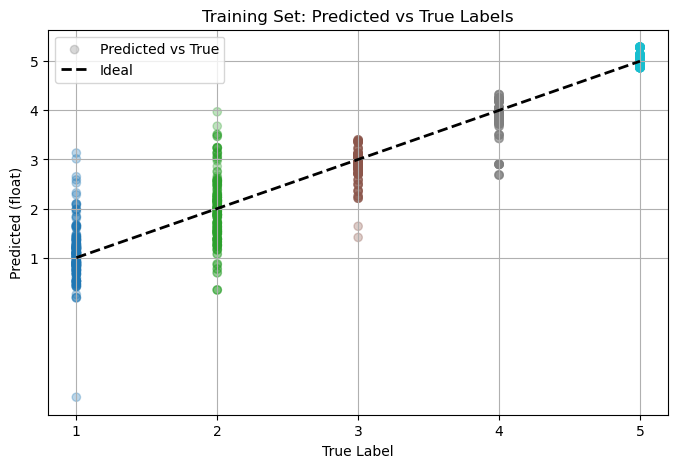

C:\Users\liuxt\AppData\Local\Temp\1\ipykernel_22916\3181035185.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors[y_true == c] for c in range(1, 6)], labels=[str(c) for c in range(1, 6)])


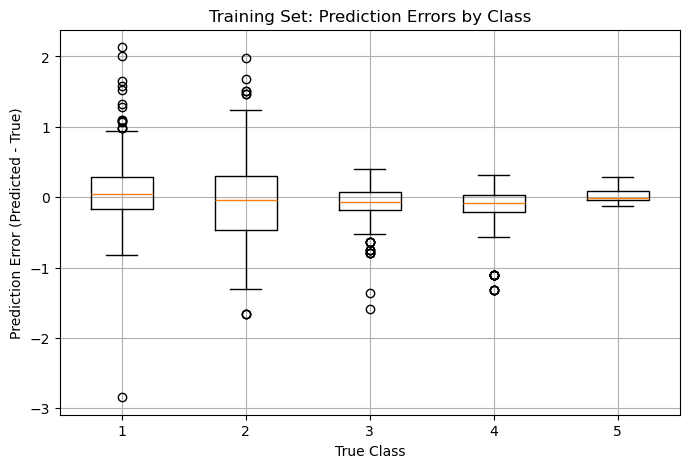

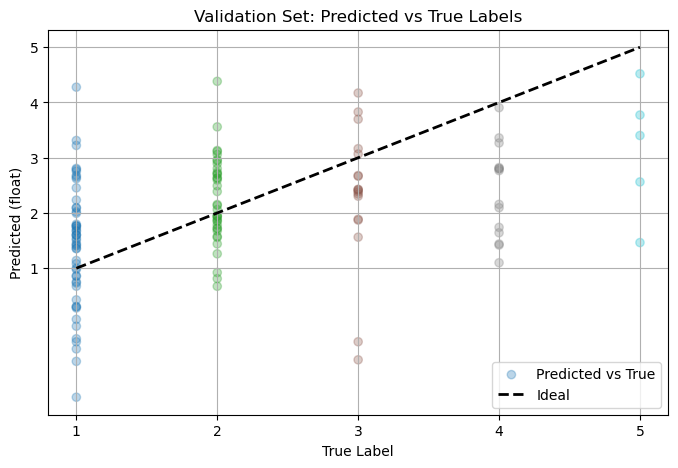

C:\Users\liuxt\AppData\Local\Temp\1\ipykernel_22916\3181035185.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors[y_true == c] for c in range(1, 6)], labels=[str(c) for c in range(1, 6)])


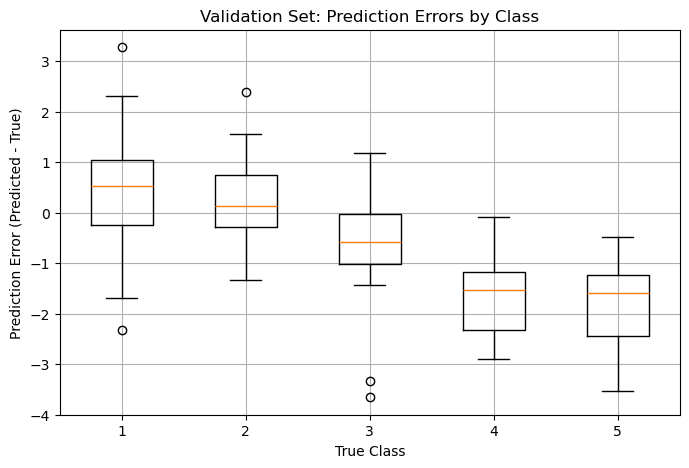

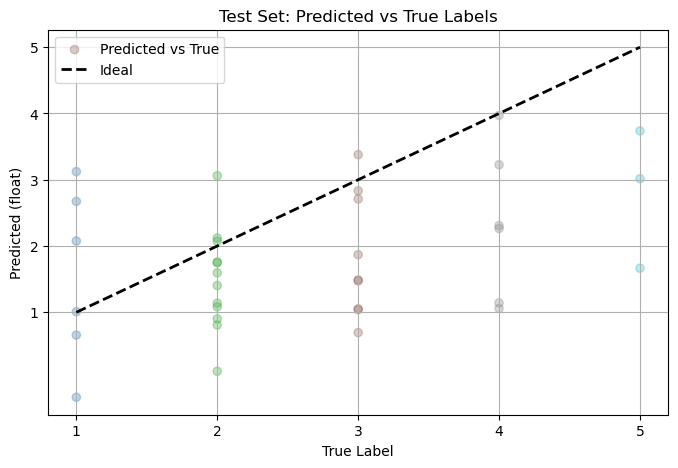

C:\Users\liuxt\AppData\Local\Temp\1\ipykernel_22916\3181035185.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors[y_true == c] for c in range(1, 6)], labels=[str(c) for c in range(1, 6)])


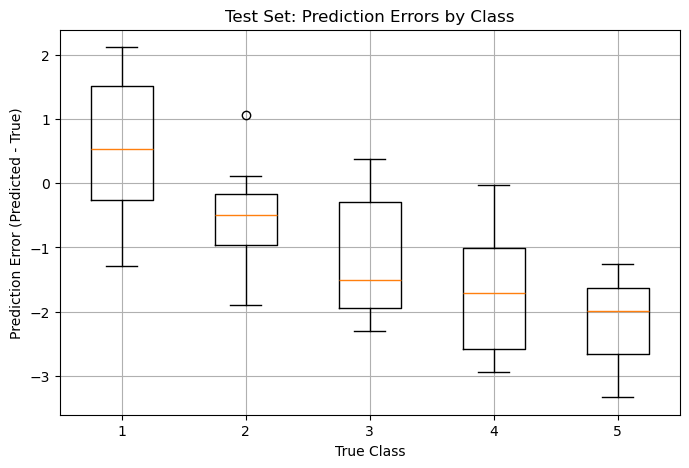

In [58]:
import matplotlib.pyplot as plt

# Helper function to plot predictions vs true labels for each class (using float predictions)
def plot_predictions_by_class(y_true, y_pred, set_name):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.3, label='Predicted vs True', c=y_true, cmap='tab10')
    plt.plot([1, 5], [1, 5], 'k--', lw=2, label='Ideal')
    plt.xlabel('True Label')
    plt.ylabel('Predicted (float)')
    plt.title(f'{set_name} Set: Predicted vs True Labels')
    plt.xticks([1,2,3,4,5])
    plt.yticks([1,2,3,4,5])
    plt.legend()
    plt.grid(True)
    plt.show()

# Helper function to plot errors by class (using float predictions)
def plot_errors_by_class(y_true, y_pred, set_name):
    errors = y_pred - y_true
    plt.figure(figsize=(8, 5))
    plt.boxplot([errors[y_true == c] for c in range(1, 6)], labels=[str(c) for c in range(1, 6)])
    plt.xlabel('True Class')
    plt.ylabel('Prediction Error (Predicted - True)')
    plt.title(f'{set_name} Set: Prediction Errors by Class')
    plt.grid(True)
    plt.show()

# Plot for training set (float predictions)
plot_predictions_by_class(y_train_true, y_train_pred.flatten(), "Training")
plot_errors_by_class(y_train_true, y_train_pred.flatten(), "Training")

# Plot for validation set (float predictions)
plot_predictions_by_class(y_val_true, y_val_pred.flatten(), "Validation")
plot_errors_by_class(y_val_true, y_val_pred.flatten(), "Validation")

# Plot for test set (float predictions)
plot_predictions_by_class(y_test_true, y_test_pred.flatten(), "Test")
plot_errors_by_class(y_test_true, y_test_pred.flatten(), "Test")

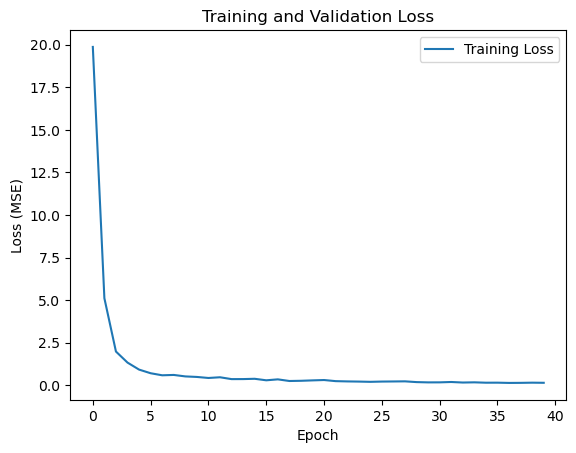

In [16]:
# Evaluate the model

plt.figure()
plt.plot(record.history['loss'], label='Training Loss')
# plt.plot(record.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
